In [6]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Running on",device)

Running on cpu


In [5]:
dat = np.genfromtxt("mnist_train.csv", delimiter = ",", skip_header = 1)

In [6]:
X, y = dat[:,1:]/255.0, dat[:,0]

X = torch.tensor(X, requires_grad=True, dtype = torch.double).view(-1,28,28).unsqueeze(1)

y = torch.tensor(y, requires_grad=False, dtype = int)

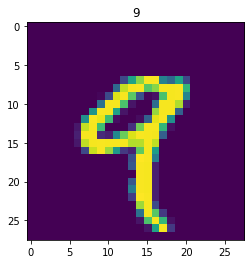

In [7]:
i = 4
plt.imshow(X[i].detach().numpy()[0])
plt.title(str(y[i].numpy()))
plt.show()

In [8]:
# def onehot(y):
#     out = torch.zeros(y.shape[0],10)
#     for i in range(y.shape[0]):
#         out[i][y[i]] = 1
#     return out

def batch_loader(X,y, batch_size = 6):
    for i in range(y.shape[0]//batch_size):
        X_out = X[i*batch_size:(i+1)*batch_size]

        y_out = y[i*batch_size:(i+1)*batch_size]

        # y_out = onehot(y_out)
        
        yield X_out, y_out

In [191]:
class CNN(nn.Module):
    def __init__(self,SIZE = 100, pretrain = -1):
        super (CNN, self).__init__()

        features = 10
        if pretrain == 0:
            features = 4
        if pretrain == 1:
            features = 2
        if pretrain == 2:
            features = 2
        if pretrain == 3:
            features = 2

        self.SIZE = SIZE

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2))
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=SIZE, kernel_size=(5, 5))
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.linear1 = nn.Linear(in_features=SIZE*4*4, out_features=SIZE*4*4//2)
        self.activation3 = nn.ReLU()

        self.output = nn.Linear(in_features=SIZE*4*4//2, out_features = features)
        # self.final_activation = nn.Softmax(dim=0)
        self.final_activation = lambda x: x

    def forward(self, x):
        x = self.activation1(self.conv1(x))
        x = self.maxpool1(x)

        x = self.activation2(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(-1,self.SIZE*4*4)
        x = self.activation3(self.linear1(x))
        x = self.output(x)

        out = self.final_activation(x)

        return out

    def pretrain(self, x, _type = 0):
        l = x.shape[0]
        _x = x.clone().detach()

        if _type == 0:
            n = np.random.randint(0,4, l)

            for i in range(l):
                _x[i] = torch.rot90(_x[i], int(n[i]), [1,2])
                
            y = n
            
        if _type == 1:
            c = np.random.random(l)<0.5

            # wow
            b = torch.tensor(c.astype(int)).unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(16,-1,28,28)

            noise = torch.randn_like(_x)*0.1 * b 
            _x = _x + noise
            
            y = c
            
        if _type == 2:
            c = np.random.random(l)<0.5

            noise = torch.roll(_x, 1, 0) * torch.tensor(c.astype(int)).unsqueeze(1).unsqueeze(2).unsqueeze(3).expand(16,-1,28,28)
            _x = _x + noise
            y = c      
        
        return _x, y





In [227]:
loss_fn = nn.CrossEntropyLoss()

batch_size = 32

def pretrain(model, n_epochs, pretrain_mode ):
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)

    model.train()
    print("Pre-training")

    for i in range(n_epochs):

        c = 0
        epoch_loss = 0
        epoch_acc = 0
        
        Loader = batch_loader(X,y, batch_size)
        pbar = tqdm(Loader, total = y.shape[0]//batch_size)
        losses = []
        for dat, _ in pbar:
            dat, label = model.pretrain(dat, pretrain_mode)
            label = torch.tensor(label, dtype = torch.long)
            
            pred = model(dat.float())

            loss = loss_fn(pred, label)

            loss.backward()
            optimizer.step()
            losses.append(loss)
            epoch_loss += loss

            corr = (label == pred.argmax(axis = 1))

            epoch_acc += corr.float().mean()
            c += 1

            if c%10 == 0:
                pbar.set_description(f"loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")
            # if c%100 == 0:
                # print(pred[:5],label[:5],pred[:5].argmax(axis = 1) == label[:5])
        print(f"Epoch {i+1}/{n_epochs} - loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")
    return losses
            

def fine_tune(model, n_epochs):
    # for param in model.parameters():
    #         param.requires_grad = False
    print("Fine-tuning")
    model.output = nn.Linear(in_features = model.SIZE*4*4//2, out_features = 10)
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.0001)
    
    losses = []
    accuracies = []
    for i in range(n_epochs):
        Loader = batch_loader(X,y, batch_size)

        c = 0
        epoch_loss = 0
        epoch_acc = 0

        pbar = tqdm(Loader, total = y.shape[0]//batch_size)
        for dat, label in pbar:
            pred = model(dat.float())

            loss = loss_fn(pred, label)

            loss.backward()
            optimizer.step()
            losses.append(loss)
            epoch_loss += loss
            acc = (label == pred.argmax(axis = 1)).float().mean()
            epoch_acc += acc
            accuracies.append(acc)
            c += 1

            if c%10 == 0:
                pbar.set_description(f"loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")
            # if c%100 == 0:
                # print(pred[:5],label[:5],pred[:5].argmax(axis = 1) == label[:5])
        print(f"Epoch {i+1}/{n_epochs} - loss {epoch_loss/c:.3} - acc {epoch_acc/c:.3}")
    return losses, accuracies

In [230]:
for pretrain_mode in [0,1,2,3]:
    print("Pretrain mode is",pretrain_mode)
    model = CNN(100, pretrain = pretrain_mode)
    model.to(device)

    pretrain_losses = pretrain(model, 10, pretrain_mode = pretrain_mode)

    losses, accuracies = fine_tune(model, 10)
    
    run = {"pretrain mode": pretrain_mode,"pretrain losses" : pretrain_losses, "fine-tune losses" : losses, "fine-tune accuracies": accuracies}
    np.save("pretain_data_"+str(pretrain_mode)+".npy", run, allow_pickle = True)
    print("finished!")

Pre-training


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 0/2 - loss 0.88 - acc 0.646


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1/2 - loss 0.545 - acc 0.806


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 